### Policy Gradient Methods
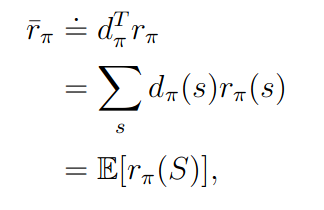

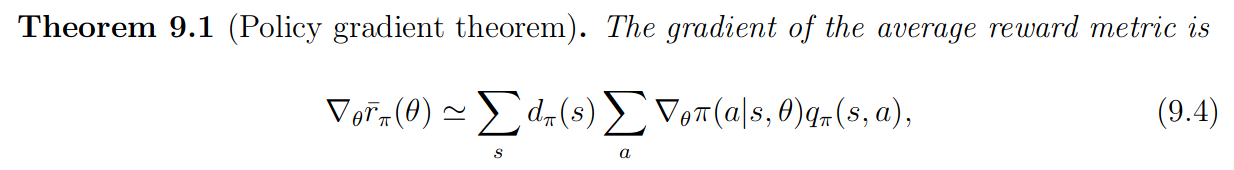

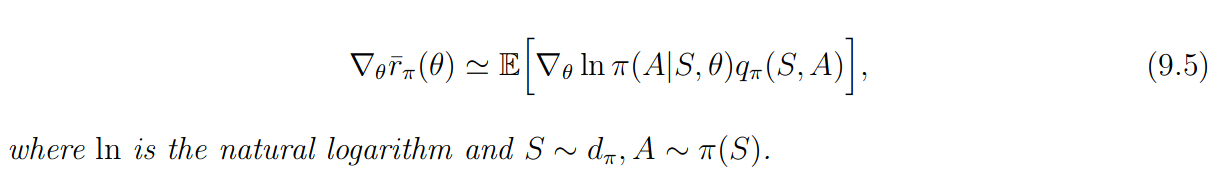

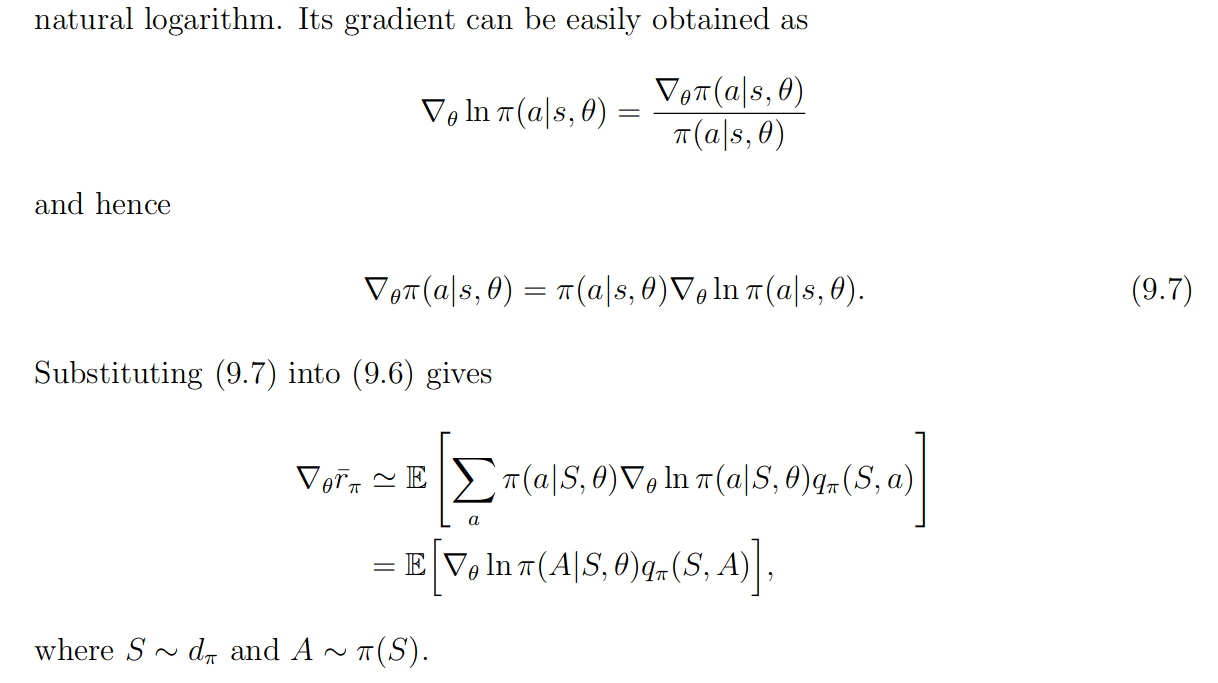

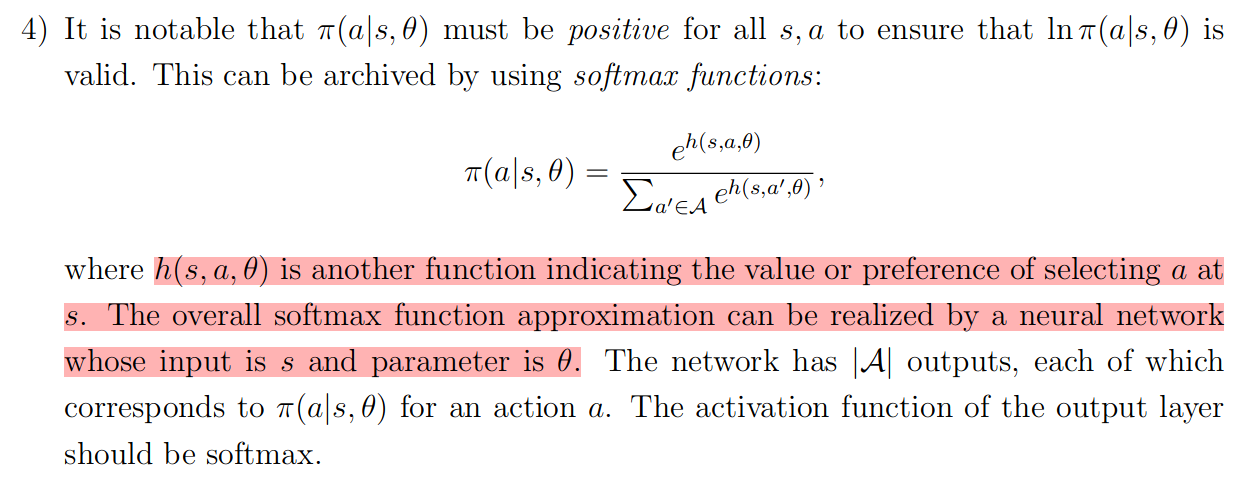

#### gradient in discounted case
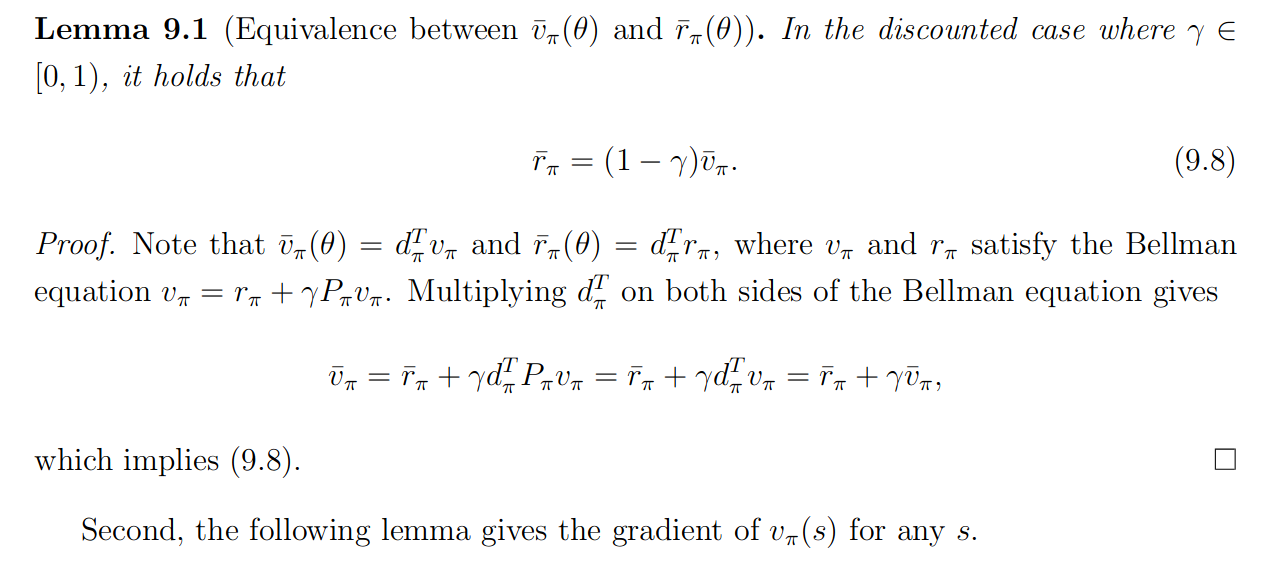

#### Policy gradient by Monte Carlo estimation

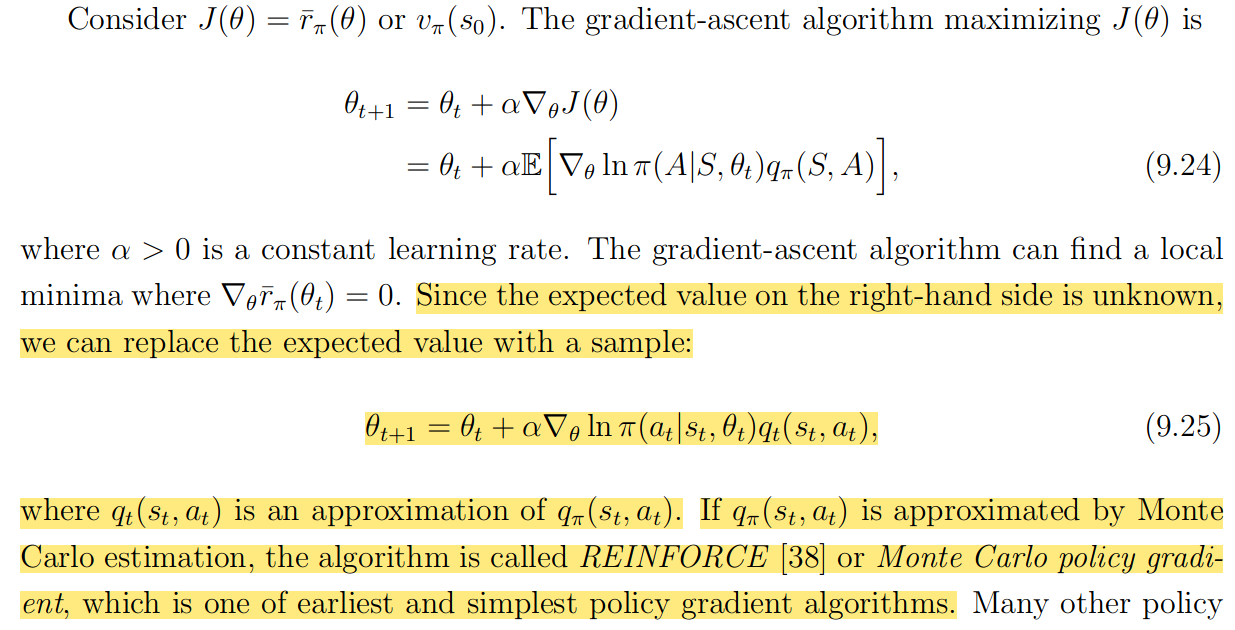

In [18]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from math import cos, pi
import random
from itertools import product
from pprint import pprint

In [19]:
def evaluate_policy(env, agent):
    s_k, info = env.reset(seed=cfg_params["random_seed"])
    terminated = False
    sum_reward = 0
    for _ in range(cfg_params["max_episode_steps"]):
        a_k = agent.select_action(s_k)
        s_k1, r_k, terminated, _ , info = env.step(a_k)
#         print(f"s_k: {s_k}, a_k: {a_k}, s_k1: {s_k1}, r_k: {r_k}, terminated: {terminated}")
        sum_reward += r_k
        s_k = s_k1
        if terminated:
            break
    return sum_reward
    

In [20]:
class LinearModel():
    def __init__(self, q_num):
        self.q_num = q_num  # 这个参数很神奇，大了小了都会影响训练效率，相当于49个参数，比起表格4*16=64个，少了15个参数
        self.omega = np.zeros(self.q_num**2)
    
    def val(self, s_k, a_k):
        return np.dot(self.grad(s_k, a_k), self.omega) 
        
    def grad(self, s_k, a_k):
        # normalize
        normal_sk = s_k/15
        normal_ak = a_k/3
        
        return np.array([cos(pi*(x[0]*normal_sk + x[1]*normal_ak)) for x in list(product(range(self.q_num), repeat=2))])

    def pprint(self):
        pprint([[round(self.val(i, j),3) for j in range(4)] for i in range(16)])

        
class PolicyModel(LinearModel):
    def __init__(self, q_num):
        super().__init__(q_num)
    
    def val(self, s_k: int, a_k: int) -> float:
        '''use parameterize policy'''
        h_func = [np.dot(self.omega, self.grad(s_k, i)) for i in range(4)]    
        pp = self.softmax(h_func)
        return pp[int(a_k)]
    
    def softmax(self, x):
        x_exp = np.exp(x)
        # 如果是列向量，则axis=0
        x_sum = np.sum(x_exp, axis=0, keepdims=True)
        s = x_exp / x_sum
        return s

In [21]:
class Agent():
    def __init__(self, action_dim: int, state_dim: int, alpha=0.01, gamma=0.9, epsilon=0.1):
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((state_dim, action_dim))  # 查表法 action value: Q(s, a)
        self.Returns = np.zeros((state_dim, action_dim))
        self.Counts = np.zeros((state_dim, action_dim))
        self.policy = PolicyModel(5)
    
    def select_action(self, s_k: int) -> int:
        self.aa = random.choices(range(4), weights=[self.policy.val(s_k, ak) for ak in range(4)])
        return self.aa[0]
    
    def train(self, data_queue: list):
        # policy evaluation
        data_array = np.array(data_queue)
        sar_set = set([(x[0], x[1]) for x in data_array])
        for (sk, ak) in sar_set:        
            first_visited_idx = [i for i, x in enumerate(data_array) if x[0] == sk and x[1] == ak]
            g = sum([(self.gamma**i)*rk for i, rk in enumerate(data_array[:, 2][first_visited_idx[0]:])])
            self.Returns[int(sk), int(ak)] += g
            self.Counts[int(sk), int(ak)] += 1
            
            self.Q[int(sk), int(ak)] = self.Returns[int(sk), int(ak)] / self.Counts[int(sk), int(ak)]
            
            delta_ln_policy = self.policy.grad(sk, ak) / self.policy.val(sk, ak)
            self.policy.omega += self.alpha * delta_ln_policy * self.Q[int(sk), int(ak)]
        
        

In [22]:
# parameter
cfg_params = {
    "env_name" : "FrozenLake-v1",
    "random_seed": 0,
    "max_train_steps": 2000,
    "max_episode_steps": 500,
}

env = gym.make(cfg_params["env_name"], desc=None, map_name="4x4", is_slippery=False) #  gym.make("CliffWalking-v0", render_mode="human")


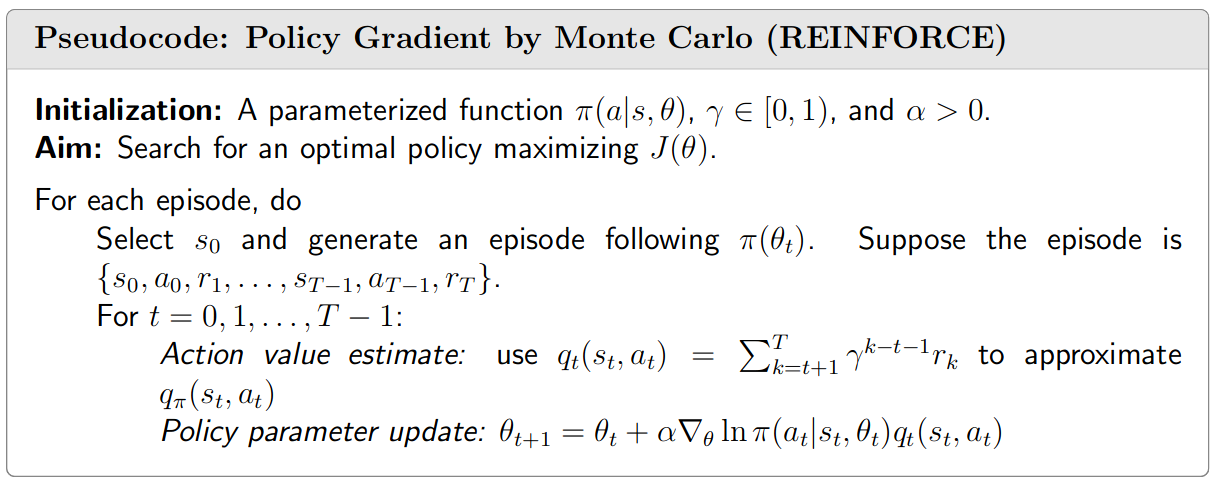
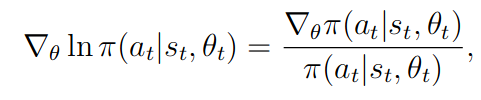

In [23]:
# make it as a funtion for data analysis

agent = Agent(
    action_dim=env.action_space.n,
    state_dim=env.observation_space.n,
    alpha=0.01,
    gamma=0.9,
    epsilon=0.5)

# training
score_queue = []

for k in range(cfg_params["max_train_steps"]):
    # reset t  he s_k
    data_queue = []
    s_k, info = env.reset(seed=cfg_params["random_seed"])
    # collect data set
    for ek in range(cfg_params["max_episode_steps"]):
        a_k = agent.select_action(s_k)
        s_k1, r_k, terminated, truncated, info = env.step(a_k)

        data_queue.append([s_k, a_k, r_k])
        if terminated:
#             print(f"s_k: {s_k}, s_k1: {s_k1}, r_k: {r_k}, a_k: {a_k}, e_k : {ek}, terminated: {terminated}")
            break
        s_k = s_k1
    
    agent.train(data_queue)

    score = evaluate_policy(env, agent)
    score_queue.append(score)
    print(f'current step: {k}/{cfg_params["max_train_steps"]}, score: {score}')

# if render:
#     evaluate_env = gym.make(cfg_params["env_name"], render_mode="human")
#     for _ in range(1):
#         evaluate_policy(evaluate_env, agent)
#     evaluate_env.close()
# print(Returns)


current step: 0/2000, score: 0.0
current step: 1/2000, score: 0.0
current step: 2/2000, score: 0.0
current step: 3/2000, score: 0.0
current step: 4/2000, score: 0.0
current step: 5/2000, score: 0.0
current step: 6/2000, score: 0.0
current step: 7/2000, score: 0.0
current step: 8/2000, score: 0.0
current step: 9/2000, score: 0.0
current step: 10/2000, score: 0.0
current step: 11/2000, score: 0.0
current step: 12/2000, score: 0.0
current step: 13/2000, score: 0.0
current step: 14/2000, score: 0.0
current step: 15/2000, score: 0.0
current step: 16/2000, score: 0.0
current step: 17/2000, score: 0.0
current step: 18/2000, score: 0.0
current step: 19/2000, score: 0.0
current step: 20/2000, score: 0.0
current step: 21/2000, score: 0.0
current step: 22/2000, score: 1.0
current step: 23/2000, score: 0.0
current step: 24/2000, score: 0.0
current step: 25/2000, score: 0.0
current step: 26/2000, score: 0.0
current step: 27/2000, score: 0.0
current step: 28/2000, score: 0.0
current step: 29/2000, s

current step: 268/2000, score: 0.0
current step: 269/2000, score: 0.0
current step: 270/2000, score: 1.0
current step: 271/2000, score: 1.0
current step: 272/2000, score: 0.0
current step: 273/2000, score: 0.0
current step: 274/2000, score: 0.0
current step: 275/2000, score: 0.0
current step: 276/2000, score: 0.0
current step: 277/2000, score: 0.0
current step: 278/2000, score: 1.0
current step: 279/2000, score: 1.0
current step: 280/2000, score: 1.0
current step: 281/2000, score: 1.0
current step: 282/2000, score: 0.0
current step: 283/2000, score: 1.0
current step: 284/2000, score: 1.0
current step: 285/2000, score: 0.0
current step: 286/2000, score: 0.0
current step: 287/2000, score: 0.0
current step: 288/2000, score: 0.0
current step: 289/2000, score: 1.0
current step: 290/2000, score: 0.0
current step: 291/2000, score: 0.0
current step: 292/2000, score: 0.0
current step: 293/2000, score: 1.0
current step: 294/2000, score: 1.0
current step: 295/2000, score: 0.0
current step: 296/20

current step: 513/2000, score: 1.0
current step: 514/2000, score: 1.0
current step: 515/2000, score: 1.0
current step: 516/2000, score: 1.0
current step: 517/2000, score: 1.0
current step: 518/2000, score: 1.0
current step: 519/2000, score: 1.0
current step: 520/2000, score: 1.0
current step: 521/2000, score: 1.0
current step: 522/2000, score: 1.0
current step: 523/2000, score: 1.0
current step: 524/2000, score: 1.0
current step: 525/2000, score: 1.0
current step: 526/2000, score: 1.0
current step: 527/2000, score: 1.0
current step: 528/2000, score: 1.0
current step: 529/2000, score: 1.0
current step: 530/2000, score: 1.0
current step: 531/2000, score: 1.0
current step: 532/2000, score: 1.0
current step: 533/2000, score: 1.0
current step: 534/2000, score: 1.0
current step: 535/2000, score: 1.0
current step: 536/2000, score: 1.0
current step: 537/2000, score: 1.0
current step: 538/2000, score: 1.0
current step: 539/2000, score: 1.0
current step: 540/2000, score: 1.0
current step: 541/20

current step: 800/2000, score: 1.0
current step: 801/2000, score: 1.0
current step: 802/2000, score: 1.0
current step: 803/2000, score: 1.0
current step: 804/2000, score: 1.0
current step: 805/2000, score: 1.0
current step: 806/2000, score: 1.0
current step: 807/2000, score: 1.0
current step: 808/2000, score: 1.0
current step: 809/2000, score: 1.0
current step: 810/2000, score: 1.0
current step: 811/2000, score: 1.0
current step: 812/2000, score: 1.0
current step: 813/2000, score: 1.0
current step: 814/2000, score: 1.0
current step: 815/2000, score: 1.0
current step: 816/2000, score: 1.0
current step: 817/2000, score: 1.0
current step: 818/2000, score: 1.0
current step: 819/2000, score: 1.0
current step: 820/2000, score: 1.0
current step: 821/2000, score: 1.0
current step: 822/2000, score: 1.0
current step: 823/2000, score: 1.0
current step: 824/2000, score: 1.0
current step: 825/2000, score: 1.0
current step: 826/2000, score: 1.0
current step: 827/2000, score: 1.0
current step: 828/20

current step: 1057/2000, score: 1.0
current step: 1058/2000, score: 1.0
current step: 1059/2000, score: 1.0
current step: 1060/2000, score: 1.0
current step: 1061/2000, score: 1.0
current step: 1062/2000, score: 1.0
current step: 1063/2000, score: 1.0
current step: 1064/2000, score: 1.0
current step: 1065/2000, score: 1.0
current step: 1066/2000, score: 1.0
current step: 1067/2000, score: 1.0
current step: 1068/2000, score: 1.0
current step: 1069/2000, score: 1.0
current step: 1070/2000, score: 1.0
current step: 1071/2000, score: 1.0
current step: 1072/2000, score: 1.0
current step: 1073/2000, score: 1.0
current step: 1074/2000, score: 1.0
current step: 1075/2000, score: 1.0
current step: 1076/2000, score: 1.0
current step: 1077/2000, score: 1.0
current step: 1078/2000, score: 1.0
current step: 1079/2000, score: 1.0
current step: 1080/2000, score: 1.0
current step: 1081/2000, score: 1.0
current step: 1082/2000, score: 1.0
current step: 1083/2000, score: 1.0
current step: 1084/2000, sco

current step: 1343/2000, score: 1.0
current step: 1344/2000, score: 1.0
current step: 1345/2000, score: 1.0
current step: 1346/2000, score: 1.0
current step: 1347/2000, score: 1.0
current step: 1348/2000, score: 1.0
current step: 1349/2000, score: 1.0
current step: 1350/2000, score: 1.0
current step: 1351/2000, score: 1.0
current step: 1352/2000, score: 1.0
current step: 1353/2000, score: 1.0
current step: 1354/2000, score: 1.0
current step: 1355/2000, score: 1.0
current step: 1356/2000, score: 1.0
current step: 1357/2000, score: 1.0
current step: 1358/2000, score: 1.0
current step: 1359/2000, score: 1.0
current step: 1360/2000, score: 1.0
current step: 1361/2000, score: 1.0
current step: 1362/2000, score: 1.0
current step: 1363/2000, score: 1.0
current step: 1364/2000, score: 1.0
current step: 1365/2000, score: 1.0
current step: 1366/2000, score: 1.0
current step: 1367/2000, score: 1.0
current step: 1368/2000, score: 1.0
current step: 1369/2000, score: 1.0
current step: 1370/2000, sco

current step: 1603/2000, score: 1.0
current step: 1604/2000, score: 1.0
current step: 1605/2000, score: 1.0
current step: 1606/2000, score: 1.0
current step: 1607/2000, score: 1.0
current step: 1608/2000, score: 1.0
current step: 1609/2000, score: 1.0
current step: 1610/2000, score: 1.0
current step: 1611/2000, score: 1.0
current step: 1612/2000, score: 1.0
current step: 1613/2000, score: 1.0
current step: 1614/2000, score: 1.0
current step: 1615/2000, score: 1.0
current step: 1616/2000, score: 1.0
current step: 1617/2000, score: 1.0
current step: 1618/2000, score: 1.0
current step: 1619/2000, score: 1.0
current step: 1620/2000, score: 1.0
current step: 1621/2000, score: 1.0
current step: 1622/2000, score: 1.0
current step: 1623/2000, score: 1.0
current step: 1624/2000, score: 1.0
current step: 1625/2000, score: 1.0
current step: 1626/2000, score: 1.0
current step: 1627/2000, score: 1.0
current step: 1628/2000, score: 1.0
current step: 1629/2000, score: 1.0
current step: 1630/2000, sco

current step: 1864/2000, score: 1.0
current step: 1865/2000, score: 1.0
current step: 1866/2000, score: 1.0
current step: 1867/2000, score: 1.0
current step: 1868/2000, score: 1.0
current step: 1869/2000, score: 1.0
current step: 1870/2000, score: 1.0
current step: 1871/2000, score: 1.0
current step: 1872/2000, score: 1.0
current step: 1873/2000, score: 1.0
current step: 1874/2000, score: 1.0
current step: 1875/2000, score: 1.0
current step: 1876/2000, score: 1.0
current step: 1877/2000, score: 1.0
current step: 1878/2000, score: 1.0
current step: 1879/2000, score: 1.0
current step: 1880/2000, score: 1.0
current step: 1881/2000, score: 1.0
current step: 1882/2000, score: 1.0
current step: 1883/2000, score: 1.0
current step: 1884/2000, score: 1.0
current step: 1885/2000, score: 1.0
current step: 1886/2000, score: 1.0
current step: 1887/2000, score: 1.0
current step: 1888/2000, score: 1.0
current step: 1889/2000, score: 1.0
current step: 1890/2000, score: 1.0
current step: 1891/2000, sco

In [24]:
agent.policy.pprint()

[[0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0]]


In [26]:
evaluate_env = gym.make(cfg_params["env_name"], render_mode="human",desc=None, map_name="4x4", is_slippery=False)
evaluate_policy(evaluate_env, agent)

1.0